In [81]:
import keras
import pandas as pd
import numpy as np
import matplotlib

In [9]:
# load data
# note: had to manually correct line 3692 -- the fields were shifted over by one place; https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data
data_raw = pd.read_csv('../data/urbandict-word-defs.csv')

# Inspect for & clean up corrupt data

In [10]:
# inspect columns; we have some extra columns indicating corrupt data
data_raw.columns

Index(['word_id', 'word', 'up_votes', 'down_votes', 'author', 'definition',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11'],
      dtype='object')

In [11]:
# pull out the data with extra columns
extra_data = data_raw[data_raw['Unnamed: 6'].notnull() | data_raw['Unnamed: 7'].notnull() | data_raw['Unnamed: 8'].notnull() | data_raw['Unnamed: 9'].notnull() | data_raw['Unnamed: 10'].notnull() | data_raw['Unnamed: 11'].notnull()]

In [14]:
# how many unique words are defined?
len(data_raw.word.unique())

663058

In [15]:
# how many words have definitions with extra columns?
len(extra_data.word.unique())

117

In [16]:
# less than 1% of the total words are affected by the corruption
117/663058

0.00017645515173634886

In [17]:
# how much of the total *data* is affected? similar proportion
len(extra_data)/len(data_raw)

0.0001945497460839711

In [26]:
data_raw.head()

,word_id,word,up_votes,down_votes,author,definition,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,7,Janky,296,255,dc397b2f,Undesirable; less-than optimum.,NaN,NaN,NaN,NaN,NaN,NaN
1,8,slumpin',16,37,dc397b2f,"low down and funky, but [knee deep] enough to ...",NaN,NaN,NaN,NaN,NaN,NaN
2,9,yayeeyay,19,27,dc397b2f,"affirmation; suggestion of encouragement, appr...",NaN,NaN,NaN,NaN,NaN,NaN
3,12,hard-core,162,96,d1610749,anything out of our league that can be good or...,NaN,NaN,NaN,NaN,NaN,NaN
4,13,brutal,12,45,40ece1ef,anything that makes you sweat,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# seems safe to drop rows that have the extra columns populated - not worth parsing out the corrupted data
data = data_raw[data_raw['Unnamed: 6'].isnull() & data_raw['Unnamed: 7'].isnull() & data_raw['Unnamed: 8'].isnull() & data_raw['Unnamed: 9'].isnull() & data_raw['Unnamed: 10'].isnull() & data_raw['Unnamed: 11'].isnull()].copy()

In [60]:
# drop the now-empty columns 
data.dropna(axis = 1, how = "all", inplace = True)

In [63]:
data.dtypes

word_id         int64
word           object
up_votes        int64
down_votes    float64
author         object
definition     object
dtype: object

In [56]:
# there are no fractional down votes, but there are some < 0?
# looked directly on Urban Dictionary and they do appear on the site... not clear how/why (seems corrupt)
test = data['down_votes'].astype('str').str.split(".", expand = True)
test[1].unique()

array(['0'], dtype=object)

In [61]:
# make the votes numeric
data['up_votes'] = pd.to_numeric(data['up_votes'])
data['down_votes'] = pd.to_numeric(data['down_votes'])

In [62]:
# there are some definitions (~ 100) with negative votes -- not clear why or how to interpret, dropping as invalid
data = data[(data['up_votes'] > 0) & (data['down_votes'] > 0)]

# Explore data

In [64]:
# make a total votes column and a vote ratio column to explore
data['total_votes'] = data['up_votes'] + data['down_votes']
data['good_ratio'] = data['up_votes'] / data['total_votes']

In [71]:
# how many words do we have? how many definitions?
print(len(data['word'].unique()))
print(len(data))
# we mostly just have one definition per word

604023
981243


In [76]:
data['total_votes'].describe()

count    973288.000000
mean        172.026745
std        1035.444874
min           3.000000
25%          15.000000
50%          39.000000
75%         106.000000
max      368136.000000
Name: total_votes, dtype: float64

In [77]:
data['good_ratio'].describe()

count    973288.000000
mean          0.527791
std           0.226837
min           0.000624
25%           0.334487
50%           0.555556
75%           0.714286
max           0.995783
Name: good_ratio, dtype: float64

In [74]:
# it seems like all the 2-vote definitions are literally identical, so should be dropped
data[data['total_votes'] ==2].describe()

,word_id,up_votes,down_votes,total_votes,good_ratio
count,7.955000e+03,7955.0,7955.0,7955.0,7955.0
mean,1.612870e+06,1.0,1.0,2.0,0.5
std,9.271169e+05,0.0,0.0,0.0,0.0
min,1.196000e+03,1.0,1.0,2.0,0.5
25%,7.327665e+05,1.0,1.0,2.0,0.5
50%,1.789698e+06,1.0,1.0,2.0,0.5
75%,2.493815e+06,1.0,1.0,2.0,0.5
max,2.856686e+06,1.0,1.0,2.0,0.5


In [75]:
data = data[data['total_votes'] > 2]

<AxesSubplot:>

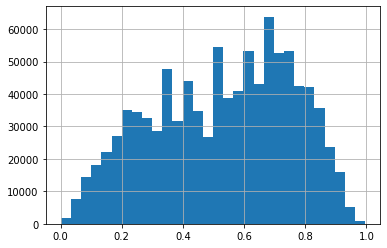

In [88]:
# mode is actaully slightly above .5
data['good_ratio'].hist(bins = 30)

In [89]:
# try equal bins and see what it looks like -- seems reasonable
data['cat'] = pd.qcut(data['good_ratio'], q = 3, labels = ["bad", "controversial", "good"])

In [91]:
# look at authors - most authors are only going to have one defn.
len(data['author'].unique())

582548

In [92]:
# clearly there is at least one author who writes a LOT more than other people
# see below - looks like it's "anonymous"
data.groupby('author').size().describe()

count    582548.000000
mean          1.670743
std          21.665324
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       15814.000000
dtype: float64

In [93]:
# confirm - there is an outlier author
data.groupby('author').size().sort_values(ascending = False)

author
a6c97ba3    15814
2438f900     1210
19de25da     1139
21cc121a      991
95a957f4      939
            ...  
a713df77        1
a714028f        1
a7141b9c        1
a7148490        1
1-Dec-56        1
Length: 582548, dtype: int64

In [94]:
# this outlier author seems to have worse definitions than the community average - mean and median are both lower
# checked directly on Urban Dictionary and this appears to be the author ID for "anonymous", so shouldn't drop
data[data['author'] == "a6c97ba3"]["good_ratio"].describe()

count    15814.000000
mean         0.463835
std          0.228927
min          0.012195
25%          0.266028
50%          0.461538
75%          0.662095
max          0.974359
Name: good_ratio, dtype: float64

In [97]:
# write this final dataset to file 
data.to_csv("../data/clean_data.csv", index = False)